In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def flat_list(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

We first load the "history.csv" file; 

In [2]:
history = pd.read_csv('../final/history.csv')
print(history.head())
end_date = max(pd.to_datetime(history['end_date'].values)) # largest end date
print('Number of distinct uids in database:', len(set(history['uid'])))

                                    uid  unit_no  start_date    end_date
0  f679a45d-40b6-46ee-b1ec-75b7183c6f88     14.0  2007-03-29  2007-03-28
1  f679a45d-40b6-46ee-b1ec-75b7183c6f88     14.0  2007-03-29  2016-06-04
2  f679a45d-40b6-46ee-b1ec-75b7183c6f88      3.0  2016-06-05         NaN
3  daca1133-5d9b-47b5-8462-4cbb1af3ba8f     15.0  2007-03-29  2007-03-28
4  daca1133-5d9b-47b5-8462-4cbb1af3ba8f     15.0  2007-03-29         NaN
Number of distinct uids in database: 32023


Create history profiles: for each uid, associate all start, end dates;

In [3]:
# history_profiles = {}
# for uid in tqdm_notebook(set(history['uid'])):
#     history_profiles[uid] = {}
#     vals = history[history['uid'] == uid].values
#     for v in vals:
#         if np.isnan(v[1]):
#             pass
#         else:
#             history_profiles[uid][int(v[1])] = v[2], v[3]
# np.save('history_profiles', history_profiles)

history_profiles = np.load('../../derived_data/history_profiles.npy', allow_pickle=1).item()

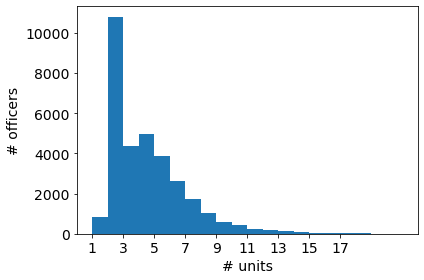

In [4]:
# distribution of number of units/officer

a = [len(history_profiles[individual_officer]) for individual_officer in history_profiles]
plt.hist(a, bins = 20)
plt.xlabel('# units', fontsize = 14)
plt.ylabel('# officers', fontsize = 14)
plt.xticks(np.arange(18)[::2], np.arange(1,19)[::2], fontsize = 14)
plt.yticks(fontsize = 14)
plt.tight_layout()
plt.show()

In [ ]:
# units_numbers = set(flat_list([list(history_profiles[k].keys()) for k in history_profiles]))
# time_in_unit = {unit : 0 for unit in units_numbers}
# plt.figure(figsize = (20,3))
# for uid in history_profiles:
#     for unit in history_profiles[uid]:
#         time_in_unit[unit] += 1
# max_unit, max_times = np.argmax([time_in_unit[u] for u in time_in_unit]), max([time_in_unit[u] for u in time_in_unit])
# plt.scatter(np.arange(max_unit), [time_in_unit[v] for v in np.sort(list(units_numbers))[:max_unit]])
# # plt.xticks(np.arange(len(units_numbers)), np.sort(list(units_numbers)))
# plt.show()

In [ ]:
# potentially interesting questions:

# how much time does an officer spend in a unit?
# officer distribution across units as time varies? 

In [5]:
roster = pd.read_csv('../final/roster.csv')
roster.head()

/Users/lorenzomasoero/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,last_name,first_name,middle_initial,gender,race,birthyear,age,status,appointment_date,position_no,...,star7,star8,star9,star10,star11,sworn,unit_id,unit_detail,star,uid
0,ABBOTT,CARMELLA,A,F,NaN,NaN,32.0,NaN,2018-02-20,9161,...,NaN,NaN,NaN,NaN,NaN,Y,37.0,NaN,NaN,de78a795-cb26-472d-a66d-667ef937f3c0
1,ABDULLAH,LAKENYA,N,F,BLACK,NaN,37.0,NaN,2004-08-31,9111,...,NaN,NaN,NaN,NaN,NaN,N,8.0,NaN,50128.0,19bb7417-a3cc-42d6-98d8-ff87e6a9d039
2,ABFALL,RICHARD,C,M,WHITE,NaN,30.0,NaN,2017-05-16,9161,...,NaN,NaN,NaN,NaN,NaN,Y,16.0,11.0,10000.0,201bfaad-7b90-41d2-9dbd-4e430e458882
3,ABOUASSI,CHADI,,M,WHITE HISPANIC,NaN,26.0,NaN,2017-05-16,9161,...,NaN,NaN,NaN,NaN,NaN,Y,15.0,10.0,10523.0,9fd1429a-ff56-40d8-912a-91e9d2a30a29
4,ABOUZEID,TAMER,NaN,M,NaN,NaN,NaN,NaN,2018-02-23,1255,...,NaN,NaN,NaN,NaN,NaN,N,83.0,NaN,NaN,8bb6007d-6ffc-4033-8292-1fe4a2993e52


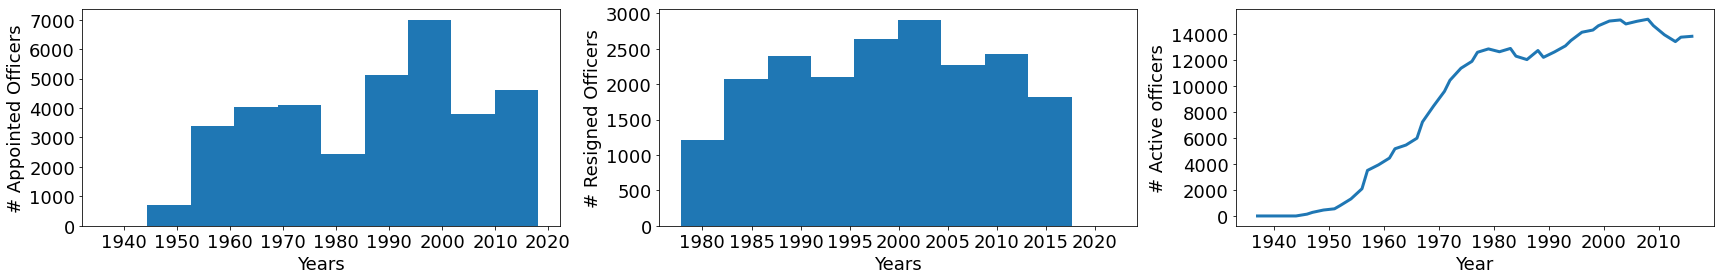

In [6]:
appointment_dates = pd.to_datetime(roster['appointment_date'].values)
resignation_dates = pd.to_datetime(roster['resignation_date'].values)

plt.figure(figsize = (24,4))
plt.subplot(131)
plt.hist(appointment_dates)
plt.xlabel('Years', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('# Appointed Officers', fontsize = 18)

plt.subplot(132)
plt.hist(resignation_dates)
plt.xlabel('Years', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('# Resigned Officers', fontsize = 18)
# plt.show()

# total number of active officers

def convert_to_year(range_time, low, high):
    delta_time = high-low
    full_date = low + range_time*delta_time
    return full_date.year

first_appointment_date, last_appointment_date = min(appointment_dates), max(appointment_dates)
delta_time = last_appointment_date - first_appointment_date
actives = (pd.to_datetime(roster['appointment_date'].values) - first_appointment_date)/delta_time
inactives = (pd.to_datetime(roster['resignation_date'].values) - first_appointment_date)/delta_time
inactives = np.nan_to_num(inactives, nan=1)
how_many_active = []
how_many_active_dropped_nans = []
range_time = np.linspace(0,1,50)
years = [convert_to_year(r, first_appointment_date, last_appointment_date) for r in range_time]
for r in range_time:
    how_many_active.append(np.sum((actives<r)*(inactives>r)))
    
plt.subplot(133)
plt.plot(years[1:-1], how_many_active[1:-1], lw = 3)
plt.ylabel('# Active officers', fontsize = 18)
plt.xlabel('Year', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.tight_layout()
plt.show()

In [12]:
gender_count, race_count, birthyear_count, status_count = roster['gender'].value_counts(), roster['race'].value_counts(), roster['birthyear'].sort_values().value_counts(), roster['status'].value_counts()
gender_count, race_count, birthyear_count, 

(M    28316
 F     7122
 X       12
 Name: gender, dtype: int64,
 WHITE                      21047
 BLACK                       8599
 WHITE HISPANIC              4811
 ASIAN/PACIFIC ISLANDER       582
 AMER IND/ALASKAN NATIVE       67
 BLACK HISPANIC                 9
 Name: race, dtype: int64,
 1947.0    921
 1948.0    858
 1946.0    810
 1970.0    799
 1949.0    767
          ... 
 1993.0     71
 1994.0     55
 1917.0     42
 1995.0     31
 1916.0     17
 Name: birthyear, Length: 80, dtype: int64)

In [77]:
yearz = roster['birthyear'].sort_values().dropna()
min_year = min(yearz.values) 
max_year = max(yearz.values)
width_year_windows = 5
binned = np.bincount((yearz - min_year)//width_year_windows)
bins = np.arange(min_year, max_year, width_year_windows, dtype = int)
bins_text = [str(bins[t])[-2:]+'-'+str(bins[t]+width_year_windows-1)[-2:] for t in range(len(bins))]

act_roster = roster[roster['resignation_date']>]
# act_yearz = roster['birthyear'].sort_values().dropna()
# width_year_windows = 5
# act_binned = np.bincount((act_yearz - min_year)//width_year_windows)

TypeError: '>' not supported between instances of 'str' and 'float'

In [93]:
pd.to_datetime(roster['resignation_date']) > pd.to_datetime('2012-03-15')

0        False
1        False
2        False
3        False
4        False
         ...  
35445    False
35446    False
35447    False
35448    False
35449    False
Name: resignation_date, Length: 35450, dtype: bool

NameError: name 'act_binned' is not defined

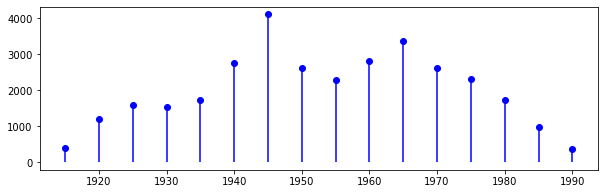

In [76]:
plt.figure(figsize = (10,3))
ax = plt.subplot(111)

plt.scatter(bins-1, binned, color = 'blue')
plt.vlines(x = bins-1, ymin = np.zeros(len(bins)), ymax = binned, color = 'blue')

plt.scatter(bins+1, act_binned, color = 'r')
plt.vlines(x = bins+1, ymin = np.zeros(len(bins)), ymax = act_binned, color = 'r')

plt.xticks(bins, bins_text)
plt.setp(ax.xaxis.get_majorticklabels(),rotation=45, ha="right", rotation_mode="anchor") 
plt.ylabel('# officers', fontsize = 15)
plt.xlabel('Birthyear', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [ ]:
NORMALIZED = True
colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  

shift = [-.2,0,.2]
fig =plt.figure(figsize = (12,3))
# plt.rc('xtick', labelsize= 50) 
plt.rc('ytick', labelsize= 35) 
# plt.rc('title', fontsize = 16)

plt.style.use('default')
gs=GridSpec(1,10) 
col = ['blue', 'red', 'green']

ax1 = fig.add_subplot(gs[0,0]) # First row, first column
cols = ['red', 'blue', 'green']
plt.scatter(np.arange(len(gender_count.values)), gender_count.values, color = cols)
plt.vlines(x = np.arange(len(gender_count.values)), ymin = np.zeros(len(gender_count.values)), ymax = gender_count.values, color = cols)
plt.xticks(np.arange(3), ['M', 'F', 'X'], fontsize = 14)
plt.xlim(-.5,2.5)

ax2=fig.add_subplot(gs[0,1:3]) 
race_ticks = {}
race_ticks['WHITE'] = 'White'
race_ticks['BLACK'] = 'Black'
race_ticks['WHITE HISPANIC'] = 'Hisp.'
race_ticks['ASIAN/PACIFIC ISLANDER'] = 'Asian'
race_ticks['AMER IND/ALASKAN NATIVE'] = 'Am. Ind.'
race_ticks['BLACK Hispanic'] = 'Bk. Hisp.'

cols = ['red', 'b', 'g', 'purple', 'orange', 'cyan']   
plt.scatter(np.arange(len(race_count.values)), race_count.values, color = cols)
plt.vlines(x = np.arange(len(race_count.values)), ymin = np.zeros(len(race_count.values)), ymax = race_count.values, colors=cols)
plt.xlabel('Race', fontsize = 15)
plt.xticks(np.arange(len(race_ticks.keys())), race_ticks.values(), fontsize = 11)

plt.setp( ax2.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 

ax3=fig.add_subplot(gs[0,3:6]) # First row, second column


plt.xticks(np.arange(len(yof_ticks)), yof_ticks, fontsize = 14)
plt.xlabel('Years on the force', fontsize = 15)
plt.setp( ax3.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.yticks([0,.2,.4,.6], [0,20,40,60], fontsize = 15)

ax5=fig.add_subplot(gs[0,6:]) # Second row, span all columns

# age_ticks = [str(20+5*k)+'-'+str(24+5*k) for k in range(len(age_dic.keys()))]
# for key in age_dic:
#     if key not in age_sh_dic.keys():
#         age_sh_dic[key] = []


# for _, dic in enumerate([age_dic, age_sh_dic]): #, age_non_sh_dic]):
    
#     sorted_age_keys, order = np.asarray(np.sort(list(dic.keys())), dtype = float), np.argsort(list(dic.keys()))
#     sorted_age_vals = np.array([len(g) for g_, g in dic.items()])[order]
#     if NORMALIZED == True:
#         sorted_age_vals = sorted_age_vals/sorted_age_vals.sum()
  
#     plt.scatter(sorted_age_keys+shift[_], sorted_age_vals, color = col[_], label = lab[_])
#     plt.vlines(x = sorted_age_keys+shift[_], ymin = np.zeros(len(sorted_age_keys)), ymax = sorted_age_vals, color = col[_])

# plt.yticks([0,.1,.2,.3], [0,10,20,30])
# plt.legend(fontsize = 15, loc = 'upper left')

# plt.xlabel('Year of Birth', fontsize = 15)
# plt.xticks(np.arange(len(age_dic.keys())), age_ticks, rotation = 90, fontsize = 14)
# plt.setp( ax5.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 

# plt.yticks(fontsize = 15)
# # plt.yticks(fontsize = 15)
fig.tight_layout()
plt.show()

In [ ]:
roster.value_counts('birthyear', bins = 10)

In [ ]:
# profiles = pd.read_csv('../final/profiles.csv')
# profiles.head()

In [ ]:
# appointment date distribution
print('Number of distinct uids in database:', len(set(profiles['uid'])))
profiles = profiles.sort_values('appointment_date', ascending=False).drop_duplicates('uid').sort_index()
# profiles.drop_duplicates(subset='uid', keep='first')
appointment_dates = pd.to_datetime(profiles['appointment_date'].values)
resignation_dates = pd.to_datetime(profiles['resignation_date'].values)

In [ ]:
plt.figure(figsize = (20,4))
plt.subplot(121)
plt.hist(appointment_dates)
plt.xlabel('Years', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('# Appointed Officers', fontsize = 18)

plt.subplot(122)
plt.hist(resignation_dates)
plt.xlabel('Years', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('# Resigned Officers', fontsize = 18)
plt.show()

In [ ]:
# total number of active officers

def convert_to_year(range_time, low, high):
    delta_time = high-low
    full_date = low + range_time*delta_time
    return full_date.year

first_appointment_date, last_appointment_date = min(appointment_dates), max(appointment_dates)
delta_time = last_appointment_date - first_appointment_date
actives = (pd.to_datetime(profiles['appointment_date'].values) - first_appointment_date)/delta_time
inactives = (pd.to_datetime(profiles['resignation_date'].values) - first_appointment_date)/delta_time
inactives = np.nan_to_num(inactives, nan=1)
how_many_active = []
how_many_active_dropped_nans = []
range_time = np.linspace(0,1,50)
years = [convert_to_year(r, first_appointment_date, last_appointment_date) for r in range_time]
for r in range_time:
    how_many_active.append(np.sum((actives<r)*(inactives>r)))
    
plt.figure()
plt.subplot(111)
plt.plot(years[1:-1], how_many_active[1:-1], lw = 3)
plt.ylabel('# Active officers', fontsize = 14)
plt.xlabel('Year', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [ ]:
# profiles = profiles.dropna(subset=['appointment_date', 'resignation_date'])

# appointment_dates = pd.to_datetime(profiles['appointment_date'].values)
# resignation_dates = pd.to_datetime(profiles['resignation_date'].values)

# first_appointment_date, last_appointment_date = min(appointment_dates), max(appointment_dates)
# delta_time = last_appointment_date - first_appointment_date
# actives = (pd.to_datetime(profiles['appointment_date'].values) - first_appointment_date)/delta_time
# inactives = (pd.to_datetime(profiles['resignation_date'].values) - first_appointment_date)/delta_time
# inactives = np.nan_to_num(inactives, nan=1)
# how_many_active = []
# how_many_active_dropped_nans = []
# range_time = np.linspace(0,1,50)
# years = [convert_to_year(r, first_appointment_date, last_appointment_date) for r in range_time]
# for r in range_time:
#     how_many_active.append(np.sum((actives<r)*(inactives>r)))

# plt.figure()
# plt.subplot(111)
# plt.plot(years[1:-1], how_many_active[1:-1], lw = 3)
# plt.ylabel('# Active officers', fontsize = 14)
# plt.xlabel('Year', fontsize = 14)
# plt.xticks(fontsize = 14)
# plt.yticks(fontsize = 14)
# plt.show()

In [ ]:
roster = pd.read_csv('../final/roster.csv', low_memory=0)
roster.head()

In [ ]:
# print(roster.columns,'\n', profiles.columns)

roster[roster['last_name']=='ABBOTT'][roster['first_name']=='CARMELLA']

In [ ]:
profiles[profiles['last_name']=='ABBOTT'][profiles['first_name']=='CARMELLA']

In [ ]:
profiles.dropna(subset = ['birthyear'])

In [ ]:
profiles = profiles = pd.read_csv('../final/profiles.csv')
roster = pd.read_csv('../final/roster.csv')
